In [14]:
import numpy as np

In [1]:
import sys, os
root = os.path.abspath("..")    # project root
sys.path.insert(0, root)
print("Project root:", root)


Project root: C:\Users\tekla\OneDrive\Documents\Machine Learning\ML-ieee-cis-fraud-detection


In [2]:
import os, sys

# 1) Capture the notebook’s original cwd (notebooks/)
orig = os.getcwd()

# 2) Compute the project root (parent of notebooks/)
project_root = os.path.abspath(os.path.join(orig, ".."))

# 3) Change the working directory there
os.chdir(project_root)
print(f"✅ Changed working dir:\n    from {orig}\n    to   {project_root}")

# 4) (Re-)add project root to sys.path for imports
if project_root not in sys.path:
    sys.path.insert(0, project_root)


✅ Changed working dir:
    from C:\Users\tekla\OneDrive\Documents\Machine Learning\ML-ieee-cis-fraud-detection\notebooks
    to   C:\Users\tekla\OneDrive\Documents\Machine Learning\ML-ieee-cis-fraud-detection


In [3]:
from src.data_cleaning import (
    load_data,
    drop_duplicates,
    drop_constant_columns,
    fill_missing,
    reduce_mem_usage
)
print("✅ data_cleaning imported!")


✅ data_cleaning imported!


In [4]:
import os

# 1️⃣ Print the notebook’s current working directory
cwd = os.getcwd()
print("🔍 Current working directory:", cwd)

# 2️⃣ Construct the expected path and check if it exists
raw_path = os.path.join(cwd, "data", "raw", "train_transaction.csv")
print("🔍 Looking for:", raw_path)
print("✅ Exists?", os.path.isfile(raw_path))
# 3️⃣ If it’s false, list out what *is* in data/raw:
if not os.path.isfile(raw_path):
    print("❗ data/raw contains:", os.listdir(os.path.join(cwd, "data", "raw")))


🔍 Current working directory: C:\Users\tekla\OneDrive\Documents\Machine Learning\ML-ieee-cis-fraud-detection
🔍 Looking for: C:\Users\tekla\OneDrive\Documents\Machine Learning\ML-ieee-cis-fraud-detection\data\raw\train_transaction.csv
✅ Exists? True


In [5]:
# ── Cell 3: Load & Cleaning Pipeline ──────────────────────────────────────────
# (Assuming you’ve already changed cwd to project root in Cell 1)

# 1) Load
df = load_data("data/raw/train_transaction.csv").head(20000)

# 2) Keep IDs & target aside
ids = df["TransactionID"].copy()
target = df["isFraud"].copy()
df = df.drop(columns=["TransactionID", "isFraud"])

print("Features before cleaning:", df.shape)

# 3) Clean
df = drop_duplicates(df)                                                # no exclude here
df = drop_constant_columns(df, threshold=0.95, exclude=["TransactionID"])  # protect any ID-like cols
df = fill_missing(df, strategy='median', exclude=["TransactionID"])
df = reduce_mem_usage(df, exclude=["TransactionID"])

# Re-attach ID and target
df["TransactionID"] = ids.values
df["isFraud"]       = target.values

print("After cleaning:", df.shape)
df.info(memory_usage='deep')


Features before cleaning: (20000, 392)
After cleaning: (20000, 357)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 357 entries, TransactionDT to isFraud
dtypes: float32(339), int16(1), int32(1), int64(2), object(14)
memory usage: 42.9 MB


C:\Users\tekla\AppData\Local\Temp\ipykernel_18232\850947587.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["TransactionID"] = ids.values
C:\Users\tekla\AppData\Local\Temp\ipykernel_18232\850947587.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["isFraud"]       = target.values


In [6]:
# ── Cell 4: Feature Engineering ───────────────────────────────────────────────
from src.feature_engineering import (
    label_encode,
    frequency_encode,
    one_hot_encode,
    create_time_features
)

# 1) Apply time features
df = create_time_features(df, time_col='TransactionDT')

# 2) Label-encode ProductCD
df = label_encode(df, 'ProductCD')

# 3) Frequency-encode card1
df = frequency_encode(df, 'card1')

# 4) One-hot encode a few small-cardinality cols
df = one_hot_encode(df, ['ProductCD'])  # e.g. ProductCD has 5 categories

print("Post-processed features:", df.shape[1], "cols")
print("Sample columns:", df.columns[:10].tolist(), "...")

df.head(3)


Post-processed features: 366 cols
Sample columns: ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2'] ...


,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,addr2,...,Transaction_day,Transaction_hour,Transaction_weekday,ProductCD_lbl,card1_freq,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,86400,68.5,13926,360.0,150.0,discover,142.0,credit,315.0,87.0,...,1,0,1,0,0.00005,False,False,False,False,True
1,86401,29.0,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,...,1,0,1,0,0.00135,False,False,False,False,True
2,86469,59.0,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,...,1,0,1,0,0.00165,False,False,False,False,True


In [8]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 262.6 kB/s eta 0:09:32
   ---------------------------------------- 0.1/150.0 MB 365.7 kB/s eta 0:06:50
   ---------------------------------------- 0.1/150.0 MB 476.3 kB/s eta 0:05:15
   ---------------------------------------- 0.1/150.0 MB 607.9 kB/s eta 0:04:07
   ---------------------------------------- 0.3/150.0 MB 1.0 MB/s eta 0:02:29
   ---------------------------------------- 0.5/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 0.7/150.0 MB 1.9 MB/s eta 0:01:19
   ---------------------------------------- 0.8/150.0 MB 2.0 MB/s eta 0:01:15
   ---------------------------------------- 0.9/150.0 MB 2.1 MB/s eta 0:01:13
   ---


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\tekla\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [17]:
# ── Cell 5: Feature Selection ─────────────────────────────────────────────────
from src.feature_selection import (
    variance_threshold_selector,
    select_k_best_univariate,
    tree_based_selection
)
from xgboost import XGBClassifier

# Split out features & target
X = df.drop(columns=['TransactionID', 'isFraud'])
y = df['isFraud']
X_numeric = X.select_dtypes(include=[np.number])


# 1) Variance threshold (e.g. drop zero‐variance)
X_var = variance_threshold_selector(X_numeric, threshold=0.0)
print("After VarianceThreshold:", X_var.shape[1], "cols")

# 2) Univariate SelectKBest
X_kbest = select_k_best_univariate(X_var, y, k=100)
print("After SelectKBest (100):", X_kbest.shape[1], "cols")

# 3) Tree-based selection (keep above median importance)
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
X_tree = tree_based_selection(X_kbest, y, model)
print("After Tree-based selection:", X_tree.shape[1], "cols")


After VarianceThreshold: 345 cols
After SelectKBest (100): 100 cols


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:48:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


After Tree-based selection: 50 cols


In [18]:
# ── Cell 6: Model Training & Evaluation ──────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# 1. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)

# 2. Train the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
model.fit(X_train, y_train)

# 3. Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

# 4. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("AUC:", auc)


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:54:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.97275
AUC: 0.7682738098982744


In [19]:
from sklearn.model_selection import GridSearchCV

# Define the model
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_tree, y)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
best_accuracy = best_model.score(X_tree, y)
best_auc = grid_search.best_score_

print(f"Best Accuracy: {best_accuracy}")
print(f"Best AUC: {best_auc}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:00:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Accuracy: 0.9787
Best AUC: 0.7911780980242924


In [21]:
# ── Cell 5: Feature Selection ─────────────────────────────────────────────────
from src.feature_selection import (
    variance_threshold_selector,
    select_k_best_univariate,
    tree_based_selection
)
from xgboost import XGBClassifier

# Split out features & target
X = df.drop(columns=['TransactionID', 'isFraud'])
y = df['isFraud']
X_numeric = X.select_dtypes(include=[np.number])

# 1) Variance threshold (e.g. drop zero‐variance)
X_var = variance_threshold_selector(X_numeric, threshold=0.0)
print("After VarianceThreshold:", X_var.shape[1], "cols")

# 2) Univariate SelectKBest
X_kbest = select_k_best_univariate(X_var, y, k=100)
print("After SelectKBest (100):", X_kbest.shape[1], "cols")

# 3) Tree-based selection (keep above median importance)
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')  # Fix warning here
X_tree = tree_based_selection(X_kbest, y, model)
print("After Tree-based selection:", X_tree.shape[1], "cols")

# ── Cell 6: Model Training & Evaluation ───────────────────────────────────────
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tree, y, test_size=0.3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Print results
print("Accuracy:", accuracy)
print("AUC:", auc)

# Cross-validation
cv_auc = cross_val_score(model, X_tree, y, cv=5, scoring='roc_auc').mean()
print("Cross-validated AUC:", cv_auc)

# ── Cell 7: Save the Model ───────────────────────────────────────────────────
import joblib

# Save the trained model to a file
joblib.dump(model, 'xgboost_model.pkl')
print("Model saved successfully.")


After VarianceThreshold: 345 cols
After SelectKBest (100): 100 cols


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:04:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


After Tree-based selection: 50 cols


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:04:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9748333333333333
AUC: 0.7690295246684011


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:04:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:04:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:04:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 

Cross-validated AUC: 0.7597481708432823
Model saved successfully.


In [22]:
import joblib

# Save the model
joblib.dump(best_model, 'xgb_model.pkl')

# Load the model back for future use
loaded_model = joblib.load('xgb_model.pkl')


<Figure size 1000x800 with 0 Axes>

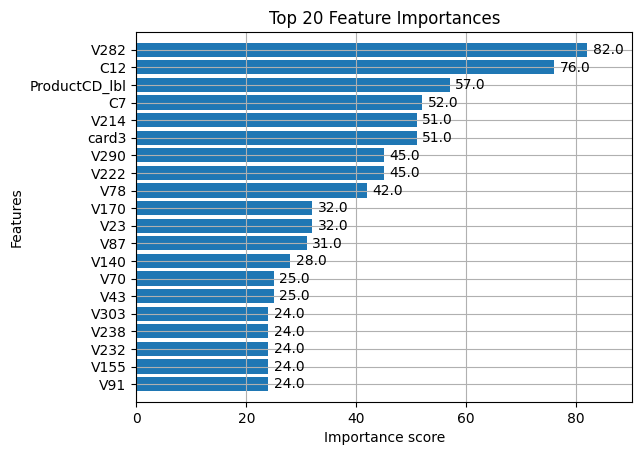

In [23]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='weight', max_num_features=20, height=0.8)
plt.title("Top 20 Feature Importances")
plt.show()


In [26]:
# ── Cell 1: Import Required Libraries ───────────────────────────────────────
import pandas as pd
import numpy as np
import os
import sys
from src.data_cleaning import (
    load_data,
    drop_duplicates,
    drop_constant_columns,
    fill_missing,
    reduce_mem_usage
)

# Set project root
root = os.path.abspath("..")
sys.path.insert(0, root)
print("Project root:", root)

# ── Cell 2: Data Cleaning ───────────────────────────────────────────────────
# Load and Clean Data
df = load_data("data/raw/train_transaction.csv").head(20000)

# Separate target and IDs
df = pd.concat([df, pd.DataFrame({"TransactionID": ids, "isFraud": target})], axis=1)
df = df.drop(columns=["TransactionID", "isFraud"])

# Clean the data
df = drop_duplicates(df)
df = drop_constant_columns(df, threshold=0.95, exclude=["TransactionID"])
df = fill_missing(df, strategy='median', exclude=["TransactionID"])
df = reduce_mem_usage(df, exclude=["TransactionID"])

# Reattach target and ids
df["TransactionID"] = ids.values
df["isFraud"] = target.values
print(f"Data cleaned: {df.shape}")

# ── Cell 3: Feature Engineering ─────────────────────────────────────────────
from src.feature_engineering import (
    label_encode,
    frequency_encode,
    one_hot_encode,
    create_time_features
)

# Apply Feature Engineering
df = create_time_features(df, time_col='TransactionDT')
df = label_encode(df, 'ProductCD')
df = frequency_encode(df, 'card1')
df = one_hot_encode(df, ['ProductCD'])

print(f"Post-processed features: {df.shape[1]} columns")

# ── Cell 4: Feature Selection ───────────────────────────────────────────────
from src.feature_selection import (
    variance_threshold_selector,
    select_k_best_univariate,
    tree_based_selection
)
from xgboost import XGBClassifier

# Split features and target
X = df.drop(columns=['TransactionID', 'isFraud'])
y = df['isFraud']
X_numeric = X.select_dtypes(include=[np.number])

# Apply Feature Selection Techniques
X_var = variance_threshold_selector(X_numeric, threshold=0.0)
X_kbest = select_k_best_univariate(X_var, y, k=100)
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
X_tree = tree_based_selection(X_kbest, y, model)

print(f"Selected features after tree-based selection: {X_tree.shape[1]} columns")

# ── Cell 5: Model Training & Evaluation ─────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_tree, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")

# ── Cell 6: Hyperparameter Tuning ───────────────────────────────────────────
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

# Fit grid search
grid_search.fit(X_tree, y)

# Best model after tuning
best_model = grid_search.best_estimator_

print(f"Best parameters found: {grid_search.best_params_}")

# ── Cell 7: Save the Model ───────────────────────────────────────────────────
import joblib

# Save the model to disk
joblib.dump(best_model, 'xgb_model.pkl')
print("Model saved successfully.")


Project root: C:\Users\tekla\OneDrive\Documents\Machine Learning


C:\Users\tekla\AppData\Local\Temp\ipykernel_18232\4282148862.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["TransactionID"] = ids.values
C:\Users\tekla\AppData\Local\Temp\ipykernel_18232\4282148862.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["isFraud"] = target.values


Data cleaned: (20000, 357)
Post-processed features: 366 columns


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:28:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Selected features after tree-based selection: 50 columns


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:28:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.97275
AUC: 0.7682738098982744
Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\tekla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [22:30:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Model saved successfully.
